Imports

In [1]:
from parameters_U233 import *
import numpy as np
import matplotlib.pyplot as plt
from jitcdde import t
from msrDynamics.objects import Node, System
import pandas as pd

In [2]:
# unpack ORNL data
df_ORNL = pd.read_csv(f"./data/ORNL_msre_{int(P)}MW_U233_insertion.csv",names=['t','dP'])
df_ORNL = df_ORNL.sort_values(df_ORNL.columns[0])
df_simulink = pd.read_excel(f"./data/simulink_msre_{P}MW_U233_insertion.xlsx")
i_trans = [i for i in range(len(df_simulink)) if df_simulink['time'][i] >= 2500]

In [3]:
T = df_simulink['time']
MSRE = System()

# radiator
T_out_rc = Node(m = mn_rp, scp = mcp_rpn/mn_rp, W = W_rp, y0 = T0_rp)
T_out_air = Node(m = mn_rs, scp = mcp_rsn/mn_rs, W = W_rs, y0 = T0_rs)

# heat exchanger
T_hf1 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p1)
T_hf2 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p2)
T_hf3 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p3)
T_hf4 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p4)
T_ht1 = Node(m = m_tn, scp = scp_t, y0 = T0_t1)
T_ht2 = Node(m = m_tn, scp = scp_t, y0 = T0_t2)
T_hc1 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s1)
T_hc2 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s2)
T_hc3 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s3)
T_hc4 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s4)

# core 
n = Node(y0 = n_frac0)
C1 = Node(y0 = C0[0])
C2 = Node(y0 = C0[1])
C3 = Node(y0 = C0[2])
C4 = Node(y0 = C0[3])
C5 = Node(y0 = C0[4])
C6 = Node(y0 = C0[5])
rho = Node(y0 = 0.0)

# add reactivity input
t_ins = 2500
def rho_insert(t):
    if (t<t_ins):
        return 0.0
    else:
        return inserted

rho_ext = MSRE.add_input(rho_insert, T)

T_cg = Node(m = mcp_g1/scp_g, scp = scp_g, y0 = T0_g1)
T_cf1 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f1)
T_cf2 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f2)

MSRE.add_nodes([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
               T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho])

# dynamics 

# radiator
T_out_rc.set_dTdt_advective(source = T_hc4.y(t-tau_hx_r))
T_out_rc.set_dTdt_convective(source = [T_out_air.y()], hA = [hA_rpn])

T_out_air.set_dTdt_advective(source = Trs_in)
T_out_air.set_dTdt_convective(source = [T_out_rc.y()], hA = [hA_rsn])

# heat exchanger
T_hf1.set_dTdt_advective(source = T_cf2.y(t-tau_c_hx))
T_hf1.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn])

T_hf2.set_dTdt_advective(source = T_hf1.y())
T_hf2.dTdt_convective = T_hf1.dTdt_convective

T_hf3.set_dTdt_advective(source = T_hf2.y())
T_hf3.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])

T_hf4.set_dTdt_advective(source = T_hf3.y())
# T_hf4.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])
T_hf4.dTdt_convective = T_hf3.dTdt_convective

# T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf2.y(),T_hc3.y(),T_hc4.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
# T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf4.y(),T_hc1.y(),T_hc2.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf1.y(),T_hc3.y(),T_hc3.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf3.y(),T_hc1.y(),T_hc1.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])

T_hc1.set_dTdt_advective(source = T_out_rc.y(t-tau_r_hx))
T_hc1.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn])

T_hc2.set_dTdt_advective(source = T_hc1.y())
T_hc2.dTdt_convective = T_hc1.dTdt_convective

T_hc3.set_dTdt_advective(source = T_hc2.y())
T_hc3.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn])

T_hc4.set_dTdt_advective(source = T_hc3.y())
T_hc4.dTdt_convective = T_hc3.dTdt_convective

# core
n.set_dndt(r = rho.y()+rho_ext, beta_eff = beta_t, Lambda = Lam, lam = lam, C = [C1.y(),C2.y(),C3.y(),C4.y(),C5.y(),C6.y()])
C1.set_dcdt(n.y(),beta[0],Lam,lam[0],tau_c,tau_l)
C2.set_dcdt(n.y(),beta[1],Lam,lam[1],tau_c,tau_l)
C3.set_dcdt(n.y(),beta[2],Lam,lam[2],tau_c,tau_l)
C4.set_dcdt(n.y(),beta[3],Lam,lam[3],tau_c,tau_l)
C5.set_dcdt(n.y(),beta[4],Lam,lam[4],tau_c,tau_l)
C6.set_dcdt(n.y(),beta[5],Lam,lam[5],tau_c,tau_l)

T_cg.set_dTdt_convective(source = [T_cf1.y()], hA = [hA_fg])
T_cg.set_dTdt_internal(source = n.y(), k = k_g*P)

T_cf1.set_dTdt_advective(source = T_hf4.y(t-tau_hx_c))
T_cf1.set_dTdt_convective(source = [T_cg.y()], hA = [k_1*hA_fg])
T_cf1.set_dTdt_internal(source = n.y(), k = k_f1*P)

T_cf2.set_dTdt_advective(source = T_cf1.y())
T_cf2.dTdt_convective = T_cf1.dTdt_convective
T_cf2.set_dTdt_internal(source = n.y(), k = k_f2*P)

rho.set_drdt(sources = [T_cf1.dydt(), T_cf2.dydt(), T_cg.dydt()], coeffs = [a_f/2,a_f/2,a_g])

In [4]:
sol_jit = MSRE.solve(T)

Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did no

In [5]:
duration = df_ORNL.iloc[-1][0]-df_ORNL.iloc[0][0]
i_insert = [i for i in range(len(T)) if (T[i] > t_ins) and (T[i] < t_ins + duration)]
ref_P = P*n.y_out[i_insert[0]-100]
dP = [(k*P)-ref_P for k in n.y_out]

delta = t_ins - df_ORNL['t'][0] - 2500
for i in range(len(df_ORNL)):
    df_ORNL['t'][i] += delta

ref_P_simulink = df_simulink['Mux(4)'][i_trans[0]-100]*P
i_window = [i for i in i_trans if df_simulink['time'][i]-2500 <= duration]

/tmp/ipykernel_47705/3527272677.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  duration = df_ORNL.iloc[-1][0]-df_ORNL.iloc[0][0]


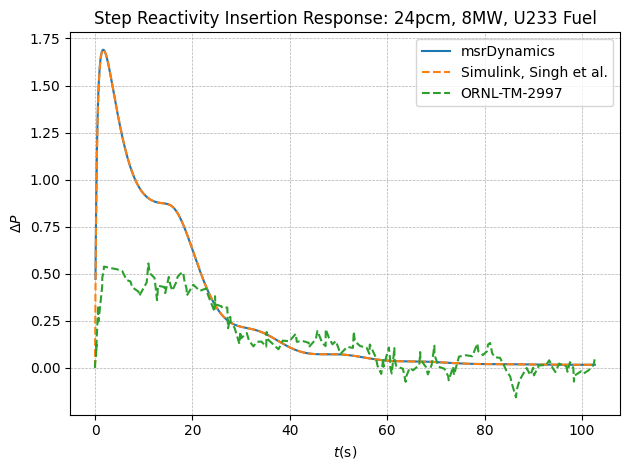

In [6]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# function to update the style of each axis
def update_axis_style(ax, title, x_label='', y_label='', x_ticks=True):
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

fig, ax = plt.subplots()
update_axis_style(ax,f"Step Reactivity Insertion Response: {int(inserted*(10**5))}pcm, {int(P)}MW, U233 Fuel")
ax.plot(T[i_insert[0]:i_insert[-1]+1]-2500,dP[i_insert[0]:i_insert[-1]+1],label="msrDynamics",color=colors[0])
ax.plot(df_simulink['time'][i_window]-2500,df_simulink['Mux(4)'][i_window]*P-ref_P_simulink,color=colors[1],linestyle="--",label="Simulink, Singh et al.")
ax.plot(df_ORNL.iloc[:,0],df_ORNL.iloc[:,1],label="ORNL-TM-2997",color=colors[2],linestyle="--")
ax.set_ylabel(r"$\Delta P$")
ax.set_xlabel(r"$t$(s)")
ax.legend()

plt.tight_layout()

In [7]:
ref_P_simulink

8.011209837859115

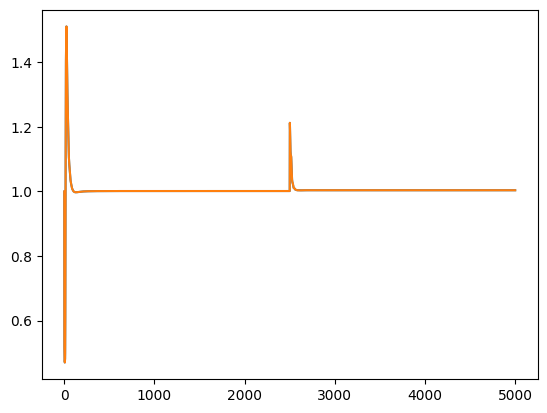

In [8]:
plt.plot(df_simulink['time'],df_simulink['Mux(4)'])
plt.plot(T,n.y_out)